In [178]:
import pandas as pd
import cobra
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import linprog
import scipy
import mip

def save_dict(data, name):
    with open(name, 'w' ) as file:
        json.dump( data, file )

# Community modeling

In this notebook we will implement a method to create community models of two or more species specific metabolic models using cobrapy.

In [179]:
model_DP = cobra.io.read_sbml_model("models/consistent_DP_SNM.xml")
model_SA = cobra.io.read_sbml_model("models/consistent_iYS854_SNM.xml")
print("Growth: ", model_DP.slim_optimize())
print("Growth: ", model_SA.slim_optimize())

Growth:  0.2823653925322476
Growth:  2.558694612613393


In [180]:
for rec in model_SA.reactions:
    rec.lower_bound = max(rec.lower_bound, -1000)
    rec.upper_bound = min(rec.upper_bound, 1000)

In [181]:
snm3 = pd.read_csv("SNM3.csv", sep =";")
snm3.head()

,Compound,BiGG,ModelSeed,KEGG
0,Alanine,ala__L,cpd00035,C00041
1,Arginine,arg__L,cpd00051,C00062
2,Cysteine,cys__L,cpd00084,C00097
3,Glutamic acid,glu__L,cpd00023,C00025
4,Glycine,gly,cpd00033,C00037


In [182]:
BIOMASS_DP = "Growth" 
BIOMASS_SA = "BIOMASS_iYS_wild_type"
models = [model_DP.copy(), model_SA.copy()]

In [183]:
import json
compm_SA = json.loads(open("compm_SA.json").read())
compm_DP = json.loads(open("compm_DP.json").read())
compm = dict(list(compm_SA.items()) + list(compm_DP.items()))

## 1) Constructing of community model explicitely

Here we introduce only shuttle reactions for reactions that are common in the uptake/sekretion reactions of the individual models!

In [184]:
def create_stoichiometry_matrix(model):
    metabolites = model.metabolites 
    reactions = model.reactions 
    S = np.zeros((len(metabolites), len(reactions)))
    
    met_id = dict()
    rec_id = dict()
    for i,reaction in enumerate(model.reactions):
        rec_id[reaction.id] = i
        for metabolite, stoich in reaction.metabolites.items():
            met_id[metabolite.id] = int(metabolites.index(metabolite))
            S[metabolites.index(metabolite), i] = stoich
    return S, met_id, rec_id 

In [185]:
class Model():
    def __init__(self, model, biomass_function):
        """ This is a new class of metabolic model, capable of flux balance analysis
        Attributes:
        models (list): CobraPy models of single organisms which will be used in construction
        biomass_reactions (list): List of strings containing the ids for the growth reactions
        """
        self.biomass_function = biomass_function
        self.model = model
        self.id = model.id
        # Compute stoichimetry_matrix
        S, met_id, rec_id = create_stoichiometry_matrix(model)
        self.num_reactions = S.shape[1]
        self.num_metabolites = S.shape[0]
        self.stoichiometry_matrix = scipy.sparse.csr_matrix(S)
        self.met_id = met_id
        self.rec_id = rec_id 
        # Set objective
        idx = self.rec_id[biomass_function]
        c = np.zeros(self.num_reactions)
        c[idx] = 1
        self.objective_c = c
        # Set bounds
        self._reset_bounds()
    
    @property
    def reactions(self):
        return self.model.reactions
    @property
    def exchanges(self):
        return self.model.exchanges
    @property
    def metabolites(self):
        return self.model.metabolites
    @property
    def medium(self):
        return self.model.medium

    def set_medium(self, medium):
        ex_ids = [ex.id for ex in self.exchanges]
        new_med = {}
        for key,val in medium.items():
            if key in ex_ids:
                new_med[key] = val
        self.model.medium = new_med
        self._reset_bounds()
        
    def optimize(self, disp=False):
        sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
        sol["fun"] = -sol["fun"] # As we have to minimize
        return sol 
    
    def slim_optimize(self, disp=False):
        sol = self.optimize(disp=disp)
        return sol["fun"]

    def summary(self):
        sol = self.optimize()
        flux = sol["x"]
        ex_ids = [ex.id for ex in self.exchanges]
        fluxes = []
        for ex in ex_ids:
            idx = self.rec_id[ex]
            fluxes.append(flux[idx])
        summary_df = pd.DataFrame({"Exchange reaction": ex_ids, "Flux": fluxes})
        summary_df.sort_values(["Flux"], inplace=True)
        return summary_df

    def _reset_bounds(self):
        self.bounds = []
        for rec in self.model.reactions:
            self.bounds.append((rec.lower_bound, rec.upper_bound))

    def __add__(self, model2):
        """ Adding another model creates a community model """
        return CommunityModel([self,model2], [1.,1.])
    

In [186]:
model_DP.medium = compm_DP 
model_SA.medium = compm_SA

In [187]:
model1 = Model(model_DP, BIOMASS_DP)
model2 = Model(model_SA, BIOMASS_SA)

$$ \max \sum_{i=1}^n \theta_i \text{ subject to }$$

$$ SV = 0, V_{j,min} \leq V_j \leq V_{j, max}, V_{Growth} \geq MBR/10 , V_{i, COOPM} + V_{i, min}\theta_i \geq V_{i,\min} $$

In [188]:
from mip import Model, xsum, maximize, BINARY

model1.set_medium(compm)
model2.set_medium(compm)

S1 = model1.stoichiometry_matrix.todense()
S1_dict = model1.rec_id 
bounds1 = model1.bounds 
obj1 = np.where(model1.objective_c > 0)[0][0]

S2 = model2.stoichiometry_matrix.todense()
S2_dict = model2.rec_id 
bounds2 = model2.bounds
obj2 = np.where(model2.objective_c > 0)[0][0]

In [189]:
from mip import Model, xsum, maximize, BINARY

comm_model = Model("COOPM")

# Shuttel reactions
x_sh = []
id1 = []
id2 = []
x_sh_dict = {}
for key, val in compm.items():
    x = comm_model.add_var(lb=-val, ub=1000)
    x_sh +=[x]
    x_sh_dict[key] = x
    if key in S1_dict:
        id1 += [S1_dict[key]]
    else:
        id1 += [None]
    if key in S2_dict:
        id2 += [S2_dict[key]]
    else:
        id2 += [None]

# Flux first model
x1 = []
for i, (lb, ub) in enumerate(bounds1): 
    x1 += [comm_model.add_var(lb = lb, ub=ub)]

# Flux second model
x2 = []
for i, (lb, ub) in enumerate(bounds2): 
    x2 += [comm_model.add_var(lb = lb, ub=ub)]
# Stoichiometry
for i in range(S1.shape[0]):
    comm_model.add_constr(xsum(S1[i,j]*x1[j] for j in range(S1.shape[1])) == 0)

for i in range(S2.shape[0]):
    comm_model.add_constr(xsum(S2[i,j]*x2[j] for j in range(S2.shape[1])) == 0)
# Shuttel constraints
for i in range(len(compm)):
    if id1[i] is not None and id2[i] is not None:
        idx1 = id1[i]
        idx2 = id2[i]
        comm_model.add_constr(-x_sh[i] + x1[idx1] + x2[idx2] == 0)
    elif id1[i] is not None:
        idx = id1[i]
        comm_model.add_constr(-x_sh[i] + x1[idx] == 0)
    else:
        idx = id2[i]
        comm_model.add_constr(-x_sh[i] + x2[idx] == 0)


In [190]:
def get_exchange_flux(S_dict, x):
    dic ={}
    for key, val in S_dict.items():
        if "EX_" in key:
            dic[key] = x[val].x
    return dic

def get_medium(x):
    dic = {}
    for key, val in x.items():
        dic[key] = val.lb
    return dic

In [191]:
comm_model.objective = maximize(0.5*x1[obj1] +0.5*x2[obj2])
comm_model.optimize()
print(x1[obj1].x)
print(x2[obj2].x)
minMBR = 0.5*(x1[obj1].x + x2[obj2].x)/10

-2.8539014533874438e-11
2.5586946127342136


In [192]:
# Single optimize
comm_model.objective = maximize(x1[obj1])
comm_model.optimize()
print(x1[obj1].x)

0.2823653925741211


In [193]:
# Single optimize
comm_model.objective = maximize(x2[obj2])
comm_model.optimize()
print(x2[obj2].x)

2.5586946126221015


In [194]:
# Check for medium
medium = get_medium(x_sh_dict)
for key in medium:
    assert key in compm

In [195]:
for key, val in get_exchange_flux(S2_dict, x2).items():
    if val < 0:
        assert key in medium
for key, val in get_exchange_flux(S1_dict, x1).items():
    if val < 0:
        if not key in medium:
            print(key, val)

EX_etha_e -6.464157931963122e-10
EX_rib__D_e -9.305122279056532e-10


In [196]:
m = Model("COOPM")

# Shuttel reactions
x_sh = []
id1 = []
id2 = []
x_sh_dict = {}
for key, val in compm.items():
    V_min = -10
    if key == "EX_o2_e":
        V_min = -20
    if "_fe" in key:
        V_min = -0.1
    x = m.add_var(lb=V_min, ub=100)
    x_sh +=[x]
    x_sh_dict[key] = x
    if key in S1_dict:
        id1 += [S1_dict[key]]
    else:
        id1 += [None]
    if key in S2_dict:
        id2 += [S2_dict[key]]
    else:
        id2 += [None]

# Flux first model
x1 = []
for i, (lb, ub) in enumerate(bounds1): 
    x1 += [m.add_var(lb = lb, ub=ub)]

# Flux second model
x2 = []
for i, (lb, ub) in enumerate(bounds2): 
    x2 += [m.add_var(lb = lb, ub=ub)]
# Stoichiometry
for i in range(S1.shape[0]):
    m.add_constr(xsum(S1[i,j]*x1[j] for j in range(S1.shape[1])) == 0)

for i in range(S2.shape[0]):
    m.add_constr(xsum(S2[i,j]*x2[j] for j in range(S2.shape[1])) == 0)
# Shuttel constraints
for i in range(len(compm)):
    if id1[i] is not None and id2[i] is not None:
        idx1 = id1[i]
        idx2 = id2[i]
        m.add_constr(-x_sh[i] + x1[idx1] + x2[idx2] == 0)
    elif id1[i] is not None:
        idx = id1[i]
        m.add_constr(-x_sh[i] + x1[idx] == 0)
    else:
        idx = id2[i]
        m.add_constr(-x_sh[i] + x2[idx] == 0)

# thetas
thetas = []
thetas_constraint = []
for x in x_sh:
    V_min = -10
    if key == "EX_o2_e":
        V_min = -20
    if "_fe" in key:
        V_min = -0.1
    theta = m.add_var(var_type=BINARY)
    thetas_constraint += [m.add_constr(x + V_min*theta >= V_min)]
    thetas.append(theta)
# Both must grow
growth_const1 = m.add_constr(x1[obj1] >= minMBR)
growth_const2 = m.add_constr(x2[obj2] >= minMBR)

In [197]:
m.objective = maximize(xsum(thetas))
m.optimize()
print(x1[obj1].x)
print(x2[obj2].x)

0.12793473063528374
0.12793473063528374


In [198]:
flux = [x.x for x in x_sh]
coopm = dict()
for f, key in zip(flux, compm.keys()):
    if f < 0:
        coopm[key] = abs(f)
save_dict(coopm, "COOPM_COM")
coopm

{'EX_zn2_e': 0.00411628289148973,
 'EX_na1_e': 0.2661195939810809,
 'EX_thm_e': 8.468734634527228e-05,
 'EX_o2_e': 10.0,
 'EX_cys__L_e': 0.09579591252857347,
 'EX_glc__D_e': 10.0,
 'EX_nac_e': 0.0015344154618546777,
 'EX_so4_e': 0.0033024108013290612,
 'EX_k_e': 0.03057313817816678,
 'EX_fe2_e': 0.01143343415693622,
 'EX_mg2_e': 0.012021930039750633,
 'EX_mobd_e': 8.955431144469861e-07,
 'EX_mn2_e': 0.004935658192463278,
 'EX_cl_e': 0.00815139273656168,
 'EX_26dap__M_e': 0.012389442368650222,
 'EX_gly_e': 10.0,
 'EX_cu2_e': 0.00419429529511705,
 'EX_ni2_e': 0.004541067459433393,
 'EX_ca2_e': 0.006650299137270015,
 'EX_cobalt2_e': 0.004522589793588469,
 'EX_thr__L_e': 0.03143040466175771,
 'EX_4abz_e': 8.28853694715312e-05,
 'EX_pro__L_e': 0.02738748182801977}

As we can see the exchanges that or not in the medium are produced by the other organism!!!

In [199]:
coopm_DP = coopm.copy()
interchange = {"DP_flux":[], "SA_flux":[]}
index = list()
for key, val in get_exchange_flux(S1_dict,x1).items():
    other_echange = get_exchange_flux(S2_dict,x2)
    if val < 0 and abs(val) > 1e-7 and key not in coopm:
        print(key, val)
        index += [key]
        interchange["DP_flux"] += [val]
        interchange["SA_flux"] += [other_echange[key]]
        if key in other_echange:
            print("Other exchange",key, other_echange[key])
        coopm_DP[key] = abs(val)

EX_leu__L_e -0.05581827859790354
Other exchange EX_leu__L_e 0.05581827859790355
EX_pi_e -0.10935376295925067
Other exchange EX_pi_e 0.10935376295925067
EX_ribflv_e -5.525691296417997e-05
Other exchange EX_ribflv_e 5.5256912964179964e-05
EX_arg__L_e -0.03664697937107785
Other exchange EX_arg__L_e 0.03664697937107786
EX_lys__L_e -0.04251573432668376
Other exchange EX_lys__L_e 0.04251573432668377
EX_glu__L_e -0.07768044081261184
Other exchange EX_glu__L_e 0.07768044081261184
EX_his__L_e -0.01173750991121185
Other exchange EX_his__L_e 0.01173750991121185
EX_ile__L_e -0.03599492301919762
Other exchange EX_ile__L_e 0.03599492301919763
EX_met__L_e -0.019068466855165837
Other exchange EX_met__L_e 0.06070163368237122
EX_trp__L_e -0.007042530725611845
Other exchange EX_trp__L_e 0.007042530725611843
EX_val__L_e -0.05310737412121919
Other exchange EX_val__L_e 0.05310737412121919
EX_phe__L_e -0.04003784585295375
Other exchange EX_phe__L_e 0.04003784585295376


In [200]:
coopm_SA = coopm.copy()
for key, val in get_exchange_flux(S2_dict,x2).items():
    other_echange = get_exchange_flux(S1_dict,x1)
    if val < 0 and key not in coopm and abs(val) > 1e-7:
        print(key, val)
        interchange["SA_flux"] += [val]
        interchange["DP_flux"] += [other_echange[key]]
        if key in other_echange:
            print("Other exchange",key, other_echange[key])
        coopm_SA[key] = abs(val)

In [201]:
#df = pd.DataFrame(interchange, index = index)
#df.to_csv("interchange_RM.csv")

This means that SA is producing stuff that DP needs ! Where SA can grow on this medium alone!

In [202]:
coopm_SA = dict([(key,val) for key,val in coopm_SA.items() if key in model_SA.exchanges])
model_SA.medium = coopm_SA
model_SA.slim_optimize()

0.13376204774118167

In [203]:
coopm_DP = dict([(key,val) for key,val in coopm_DP.items() if key in model_DP.exchanges])
model_DP.medium = coopm_DP
model_DP.slim_optimize()

0.1279347306352838

## Sensitivity analysis

In [204]:
Des = pd.read_csv("Descriptive_name.csv", sep =";")

In [205]:
SA_growths = {}
DP_growths = {}
for i,key in enumerate(coopm): 
    vals = np.linspace(-10,0, 100)
    for val in vals:
        x_sh[i].lb = val
        m.objective = maximize(x1[obj1] + x2[obj2])
        m.optimize()
        if key in SA_growths and key in DP_growths:
            DP_growths[key].append(x1[obj1].x)
            SA_growths[key].append(x2[obj2].x)
        else:
            DP_growths[key] = [x1[obj1].x]
            SA_growths[key] = [x2[obj2].x]
    x_sh[i].lb = -coopm[key]

In [206]:
title_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'normal'} 

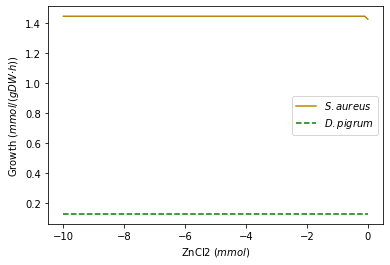

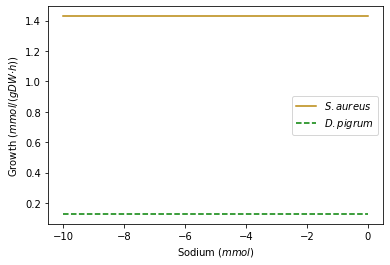

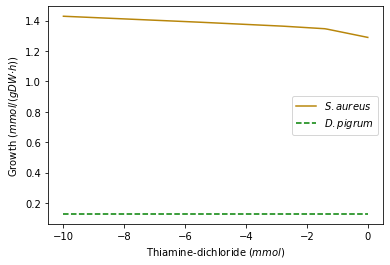

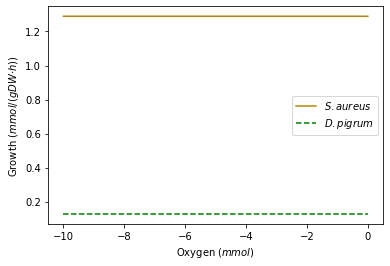

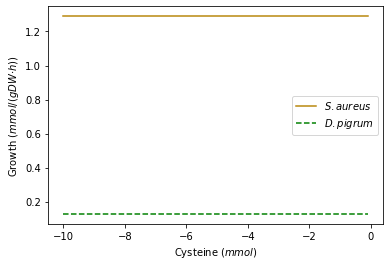

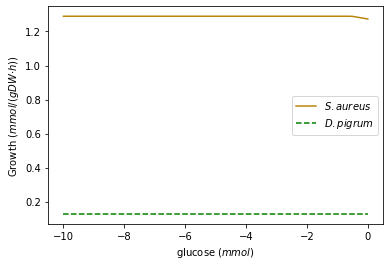

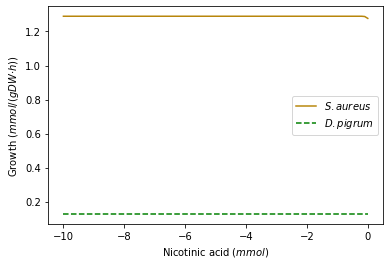

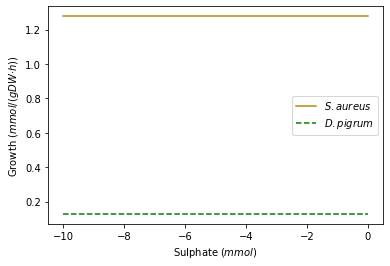

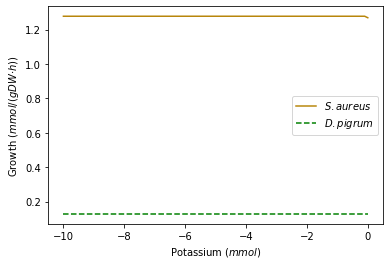

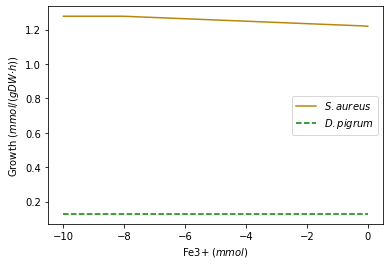

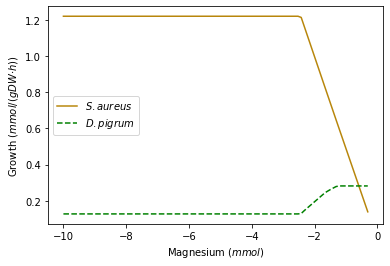

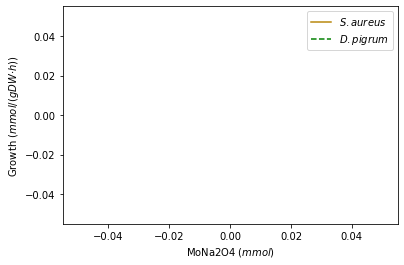

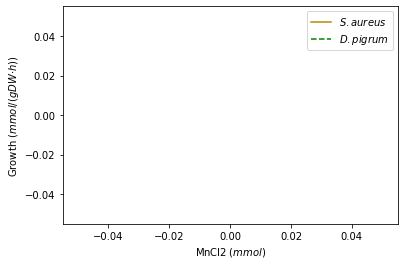

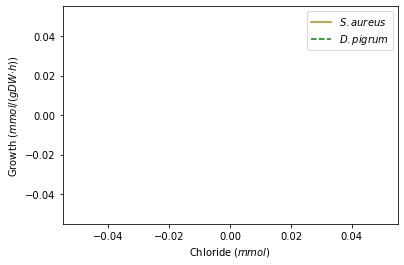

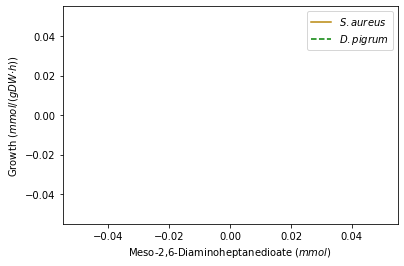

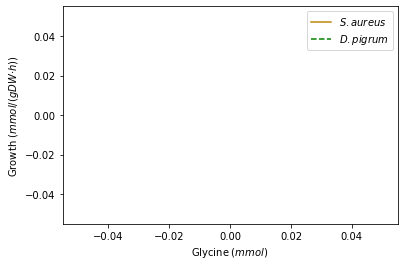

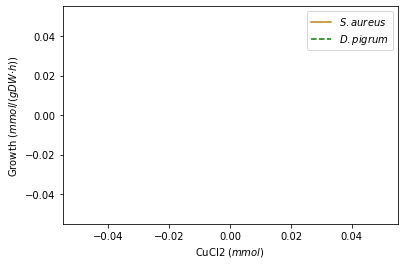

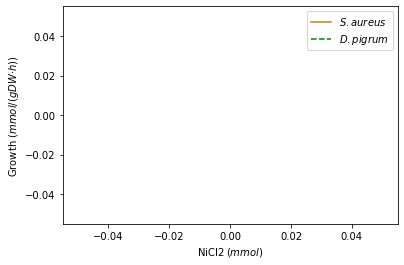

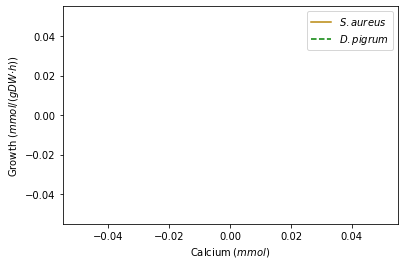

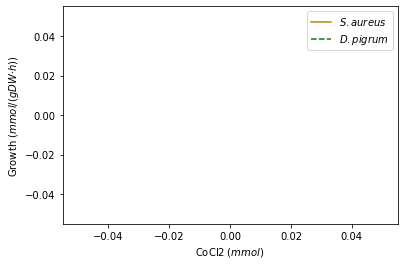

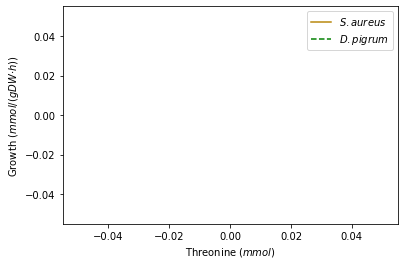

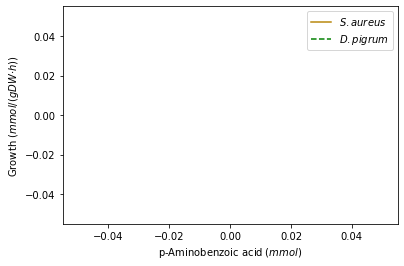

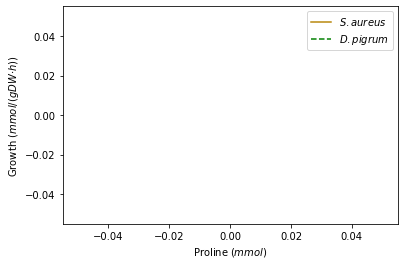

In [207]:
for key in coopm:
    for j in range(len(Des)):
        ide = "EX_" + str(Des.iloc[j][1]) + "_e"
        if key == ide :
            #plt.title(key)
            plt.plot(vals, SA_growths[key], 'darkgoldenrod')
            plt.plot(vals, DP_growths[key], 'g--')
            plt.legend(["$\it{S.aureus}$" , "$\it{D. pigrum}$"])
            plt.xlabel(str(Des.iloc[j][0]) +  "$\;(\it{mmol})$")
            plt.ylabel("Growth $(\it{mmol/(gDW⋅h)})$")
            plt.savefig(key + "COOPM", bbox_inches='tight', dpi=1000)  
            plt.show()